In [527]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [175]:
#データのダウンロード
train_data = pd.read_csv('csv/train.csv', index_col=0)
test_data = pd.read_csv('csv/test.csv', index_col=0)
val_data = pd.read_csv('csv/sample_submission.csv', index_col=0, header=None)

In [14]:
train_data.head()

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,2015-06-29,14,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,English oak,...,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,...,BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15
2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,...,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51
3,2016-05-09,15,OnCurb,0,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,...,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51
4,2016-06-24,23,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,...,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9


In [17]:
#訓練データのデータ、特徴量数
train_data.shape

(19984, 21)

In [176]:
train_df = train_data.copy()
test_df = test_data.copy()

In [203]:
"""
不均衡データ
"""
train_df['health'].value_counts().sort_index()

health
0     3535
1    15751
2      698
Name: count, dtype: int64

In [178]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19984 entries, 0 to 19983
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  19984 non-null  object
 1   tree_dbh    19984 non-null  int64 
 2   curb_loc    19984 non-null  object
 3   health      19984 non-null  int64 
 4   steward     5101 non-null   object
 5   guards      5041 non-null   object
 6   sidewalk    19984 non-null  object
 7   user_type   19984 non-null  object
 8   problems    7741 non-null   object
 9   spc_common  19984 non-null  object
 10  spc_latin   19984 non-null  object
 11  nta         19984 non-null  object
 12  nta_name    19984 non-null  object
 13  borocode    19984 non-null  int64 
 14  boro_ct     19984 non-null  int64 
 15  boroname    19984 non-null  object
 16  zip_city    19984 non-null  object
 17  cb_num      19984 non-null  int64 
 18  st_senate   19984 non-null  int64 
 19  st_assem    19984 non-null  int64 
 20  cncldist   

In [179]:
#各特徴量の欠損値数
train_df.isnull().sum()

created_at        0
tree_dbh          0
curb_loc          0
health            0
steward       14883
guards        14943
sidewalk          0
user_type         0
problems      12243
spc_common        0
spc_latin         0
nta               0
nta_name          0
borocode          0
boro_ct           0
boroname          0
zip_city          0
cb_num            0
st_senate         0
st_assem          0
cncldist          0
dtype: int64

In [180]:
#欠損値を含む特徴量のデータ確認
print(train_df['steward'].value_counts())
print('-'*30)
print(train_df['guards'].value_counts())
print('-'*30)
print(train_df['problems'].value_counts())
print('-'*30)
print('problemsのユニークデータ数')
train_df['problems'].unique().shape[0]

steward
1or2       3999
3or4       1079
4orMore      23
Name: count, dtype: int64
------------------------------
guards
Helpful    3650
Unsure      737
Harmful     654
Name: count, dtype: int64
------------------------------
problems
Stones                                  2219
BranchLights                            1036
StonesBranchLights                       762
BranchOther                              408
RootOther                                333
                                        ... 
StonesRootOtherTrunkOtherBranchOther       8
StonesRootOtherWiresRopeBranchOther        5
StonesMetalGratesTrunkOther                4
TrunkLightsBranchLightsBranchOther         4
WiresRopeTrunkLightsBranchLights           4
Name: count, Length: 73, dtype: int64
------------------------------
problemsのユニークデータ数


74

In [48]:
#欠損値をNULLに置き換え
train_df.fillna('NULL', inplace=True)
train_df.isnull().sum()

created_at    0
tree_dbh      0
curb_loc      0
health        0
steward       0
guards        0
sidewalk      0
user_type     0
problems      0
spc_common    0
spc_latin     0
nta           0
nta_name      0
borocode      0
boro_ct       0
boroname      0
zip_city      0
cb_num        0
st_senate     0
st_assem      0
cncldist      0
dtype: int64

In [181]:
#problemを問題あり、なしのバイナリデータに変換
train_df['bool_problems'] = train_df['problems'].apply(lambda x: 0 if x == 'NULL' else 1)

In [182]:
train_df[['bool_problems', 'problems']].head(10)

,bool_problems,problems
0,1,NaN
1,1,NaN
2,1,StonesBranchLights
3,1,NaN
4,1,Stones
5,1,NaN
6,1,BranchLights
7,1,NaN
8,1,NaN
9,1,Stones


Text(0.5, 1.0, 'health vs tree_dbh')

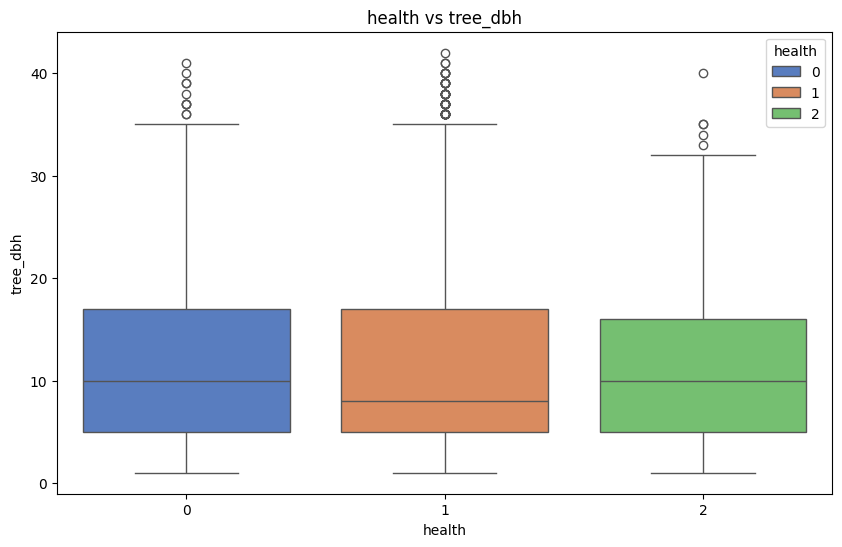

In [66]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='health', y='tree_dbh', data=train_df, hue='health', palette="muted")
plt.title('health vs tree_dbh')

In [78]:
train_df[['tree_dbh', 'health']].groupby('health').mean()

,tree_dbh
health,
0,11.827157
1,11.676465
2,11.441261


In [189]:
#木の胸高直径の20越えの割合（health毎）

#tree_dbhが20overの数をhealth毎に抽出
over20_tree = train_df[train_df['tree_dbh'] > 20].groupby('health').count()

#health毎のtree_dbhの数
tree_con = train_df[['tree_dbh', 'health']].groupby('health').count()

#割合算出
over20_ratio =(over20_tree['tree_dbh'] / tree_con['tree_dbh'])*100
over20_ratio

"""
健康状態が悪い木はtree_dbhが小さい割合が多いかも
"""

'\n健康状態が悪い木はtree_dbhが小さい割合が多いかも\n'

In [192]:
categorical_col =  ['curb_loc', 'sidewalk', 'steward', 'guards', 'user_type', 'bool_problems']

'\nチュートリアルのものをそのまま模写したが、\nhealth=3の数が他の2つに比べて非常に少ないので、healthのカテゴリ毎の割合で出さないと意味がない。\n\n'

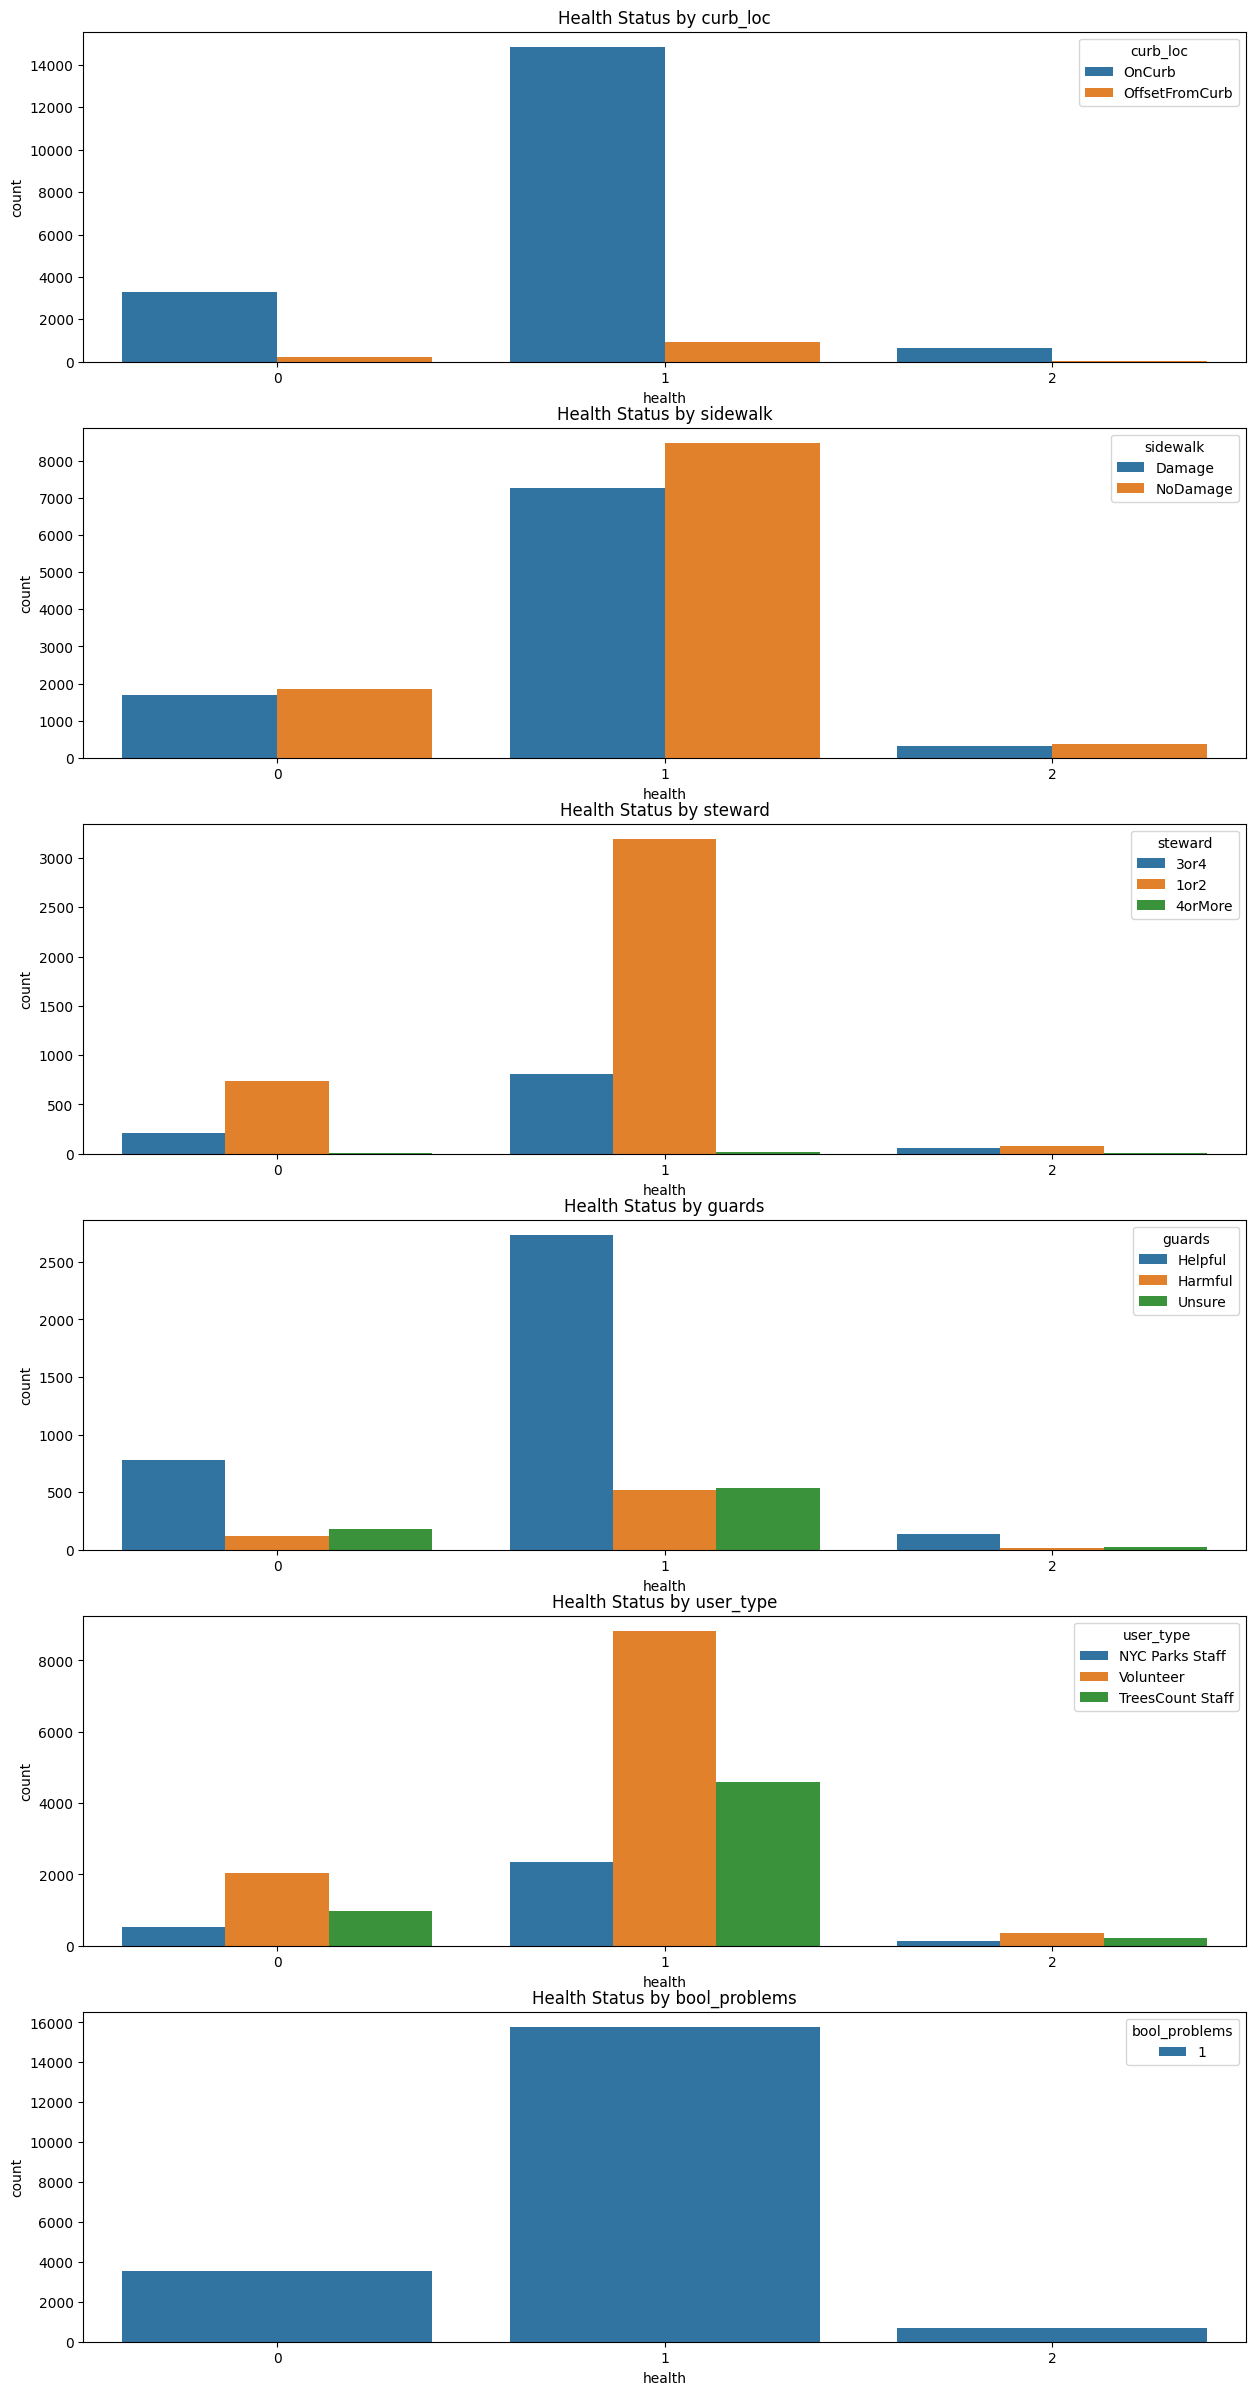

In [183]:

fig, axes = plt.subplots(len(categorical_col), 1, figsize=(15, 30))
for i, col in enumerate(categorical_col):
    sns.countplot(x='health', hue=col, data=train_df, ax=axes[i])
    axes[i].set_title(f'Health Status by {col}')
    axes[i].legend(title=col, loc='best')
    
"""
チュートリアルのものをそのまま模写したが、
health=3の数が他の2つに比べて非常に少ないので、healthのカテゴリ毎の割合で出さないと意味がない。

"""

In [269]:
#healthの追加した特徴量
categorial_ratio_col = ['curb_loc', 'sidewalk', 'steward', 'guards', 'user_type', 'bool_problems', 'health']

#health毎のカウント数
categorical_cont = train_df[categorial_ratio_col].groupby('health').count()

#health毎のデータ数
health_con = train_df['health'].value_counts().sort_index()

In [768]:
#カテゴリーデータ別にhealhtラベルに合わせた割合のdfを返す関数

def categorical_ratio(train_data, col_name):
    
    #healthの[0,1,2]を抽出
    health_label = np.sort(train_data['health'].unique())
    
    #healthラベル毎のカウント数
    health_con = train_df['health'].value_counts().sort_index()
    
    list_data = []
    for label in health_label:

        #各ラベルデータ
        label_df = train_df[train_df['health']==label]

        #ユニーク値に対する割合
        col_count = label_df[col_name].value_counts().values
        ratio_data = col_count / health_con[label]
        list_data.append(ratio_data)
        
    #nanの除去    
    col_list = train_df[col_name].value_counts().index.values
    
    #df化
    result_df = pd.DataFrame(list_data, index=health_label.astype(str), columns=col_list.tolist() )
    
    
    
    return result_df

In [769]:
col_list.tolist()

['OnCurb', 'OffsetFromCurb']

In [788]:
categorical_ratio(train_df, 'curb_loc')

,OnCurb,OffsetFromCurb
0,0.934936,0.065064
1,0.941274,0.058726
2,0.925501,0.074499


<Axes: >

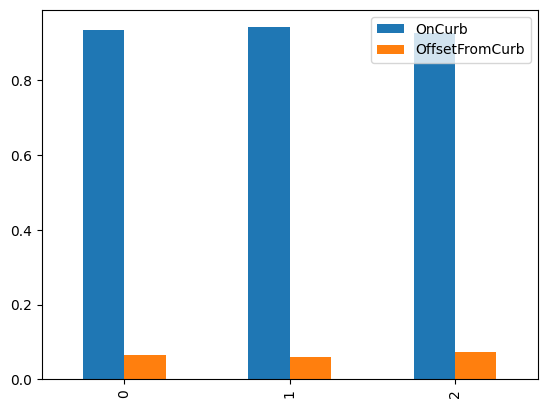

In [789]:
categorical_ratio(train_df, 'curb_loc').plot.bar()

<Axes: >

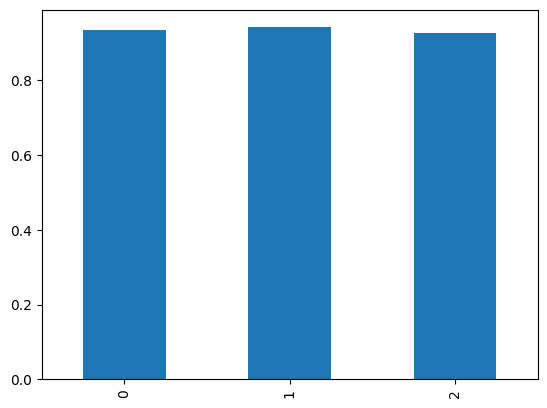

In [771]:
categorical_ratio(train_df, 'curb_loc').iloc[:, 0].plot.bar()

<Axes: >

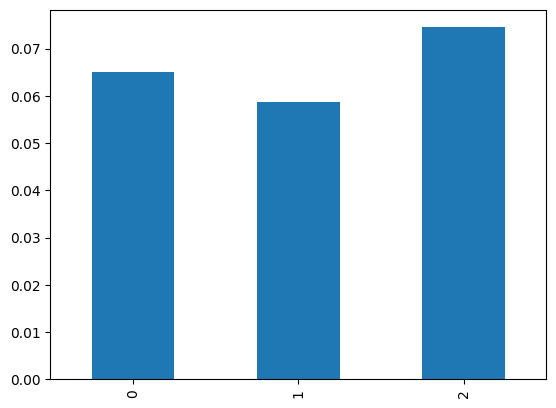

In [778]:
categorical_ratio(train_df, 'curb_loc').iloc[:, 1].plot.bar()

In [773]:
categorical_ratio(train_df, 'sidewalk')

,NoDamage,Damage
0,0.521075,0.478925
1,0.537934,0.462066
2,0.535817,0.464183


<Axes: >

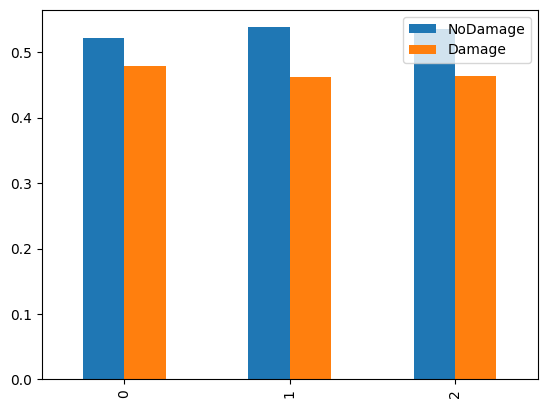

In [777]:
categorical_ratio(train_df, 'sidewalk').plot.bar()

In [780]:
categorical_ratio(train_df, 'steward')

,1or2,3or4,4orMore
0,0.208487,0.059689,0.000849
1,0.202400,0.051489,0.001016
2,0.106017,0.081662,0.005731


<Axes: >

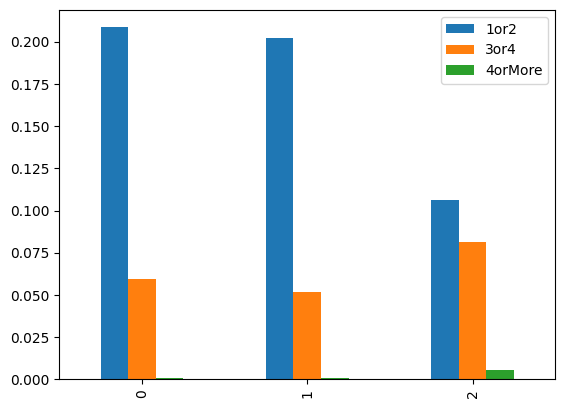

In [782]:
categorical_ratio(train_df, 'steward').plot.bar()

In [783]:
categorical_ratio(train_df, 'user_type')

,Volunteer,TreesCount Staff,NYC Parks Staff
0,0.573975,0.274116,0.151909
1,0.559520,0.292108,0.148372
2,0.497135,0.322350,0.180516


<Axes: >

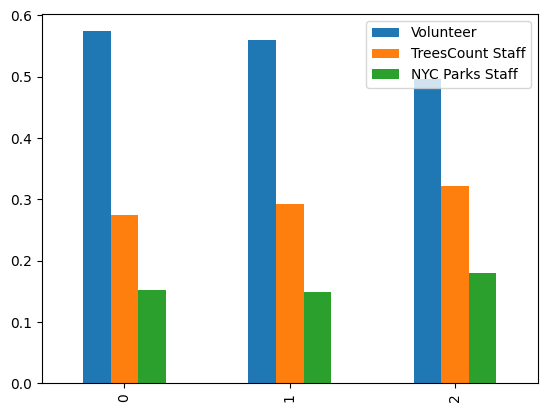

In [776]:
categorical_ratio(train_df, 'user_type').plot.bar()

In [790]:
train_df[['health','curb_loc']].value_counts()[0]

curb_loc
OnCurb            3305
OffsetFromCurb     230
Name: count, dtype: int64

In [676]:
train_df['health'].value_counts().sort_index()

health
0     3535
1    15751
2      698
Name: count, dtype: int64